In [146]:
import nltk
import re
import string
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from pymorphy2 import MorphAnalyzer

from IPython.display import display
# from tqdm import tqdm
# import ast

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 

Loading BokehJS ...

In [3]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [44]:
df = pd.read_csv('data/train.csv', sep=';', encoding='utf-8')
df = df[['ucid', 'text_employer', 'date', 'ACTION_ITEM_RESULT_PRODUCT_NAME']]
df.head()

ucid                                      text_employer   
0  5.010388e+17  добрый_день. это ваш персональный_менеджер_сбе...  \
1  5.010389e+17  добрый_день строки. это клиентский_менеджер_сб...   
2  5.010397e+17  здравствуйте. это ваши персональный_менеджер и...   
3  5.010401e+17  добрый_день. персональный_менеджер сбер бизнес...   
4  5.010405e+17  в истории смотреть. добрый_день. менеджер_сбер...   

         date ACTION_ITEM_RESULT_PRODUCT_NAME  
0  2021-02-26                    Бизнес-карта  
1  2021-02-20              Зарплатные проекты  
2  2021-02-18              Зарплатные проекты  
3  2021-02-24              Зарплатные проекты  
4  2021-02-20              Зарплатные проекты

In [158]:
n_topics = 8

In [99]:
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def replace_symbol(x):
    return x.replace('_', ' ')

def remove_stopwords(doc):
    filtered_doc = [token for token in word_tokenize(doc) if not token in stop_words] 
    return " ".join(filtered_doc)

def lemmatize(doc):
    tokens = [morph.normal_forms(token)[0] for token in word_tokenize(doc)]
    return " ".join(tokens)

def update_stop_words(stop_words):
    stop_words = remove_stop_words(stop_words)
    stop_words = add_stop_words(stop_words)
    return stop_words

def remove_stop_words(stop_words):
    remove_list = ['сейчас', 'через', 'какое', 'могу', 'тогда', 'до', ]
    return set(stop_words - set(remove_list))

def add_stop_words(stop_words):
    new_words = ['э', 'а', 'м', 'к', 'же', 'у', 'box', 'санкт-петербург', 'москва', 'это', 'лопух', 'вот', 'там', 'психоз', 'ну',
    'этот', 'уже', 'сантиметров', 'жесткая', 'она', 'прям', 'вообще', 'пошел', 'звоним', 'штоб', 'бога', 'на', 'максим',
    'или', 'мастер', 'кого', 'ой', 'по', 'выходной', 'давай', 'пизда', 'блядь', 'истории', 'пари', 'виктория', 'ma', 'ager', 'июль',
                'возможно', 'тот', 'например', 'какой-либо', 'какой-то', 'по-моему', 'когда-то', 'суббота', 'вера', 'март',
                 'gear', 'московский', 'новосибирск', 'район', 'календарь', 'турция', 'город', 'маэстро', 'как-нибудь', 'либо',
                'примерно', 'который', 'поиздевался', 'поиздеваться', 'ежику', 'еж']
    
    stop_this_task = ['абсолютно', 'во', 'всякий', 'всё', 'где', 'нигде', 'где-то', 'какой-то', 'тольятти', 'воронеж', 'б', 
                 'есть', 'мать', 'давно', 'тот', 'за', 'дополнительно', 'дополнительный', 'друг', 'тогда', 'из', 'ка', 
                  'как', 'кбк', 'очень', 'кто', 'кстати', 'кратко', 'надежда', 'московский', 'момент', 'моментально',
                  'моментальный', 'наверное', 'что-то', 'насколько', 'нету', 'очень', 'по', 'пока', 'раз', 'что']
    new_words.extend(stop_this_task)
    return set(list(stop_words) + new_words)

In [100]:
# data preprocessing
stop_words = update_stop_words(stop_words)

df_filtered = df.copy()

# removing short texts
df_filtered = df_filtered[(df_filtered['text_employer'].str.len() > 3)]

df_filtered = df_filtered.drop_duplicates(subset=['text_employer'])

string.punctuation = string.punctuation.replace('-','')
#removing stopwords, punctuations, digits, correcting phrases like 'добрый_день'
df_filtered.text_employer = df_filtered.text_employer.apply(lambda t : t.lower())
df_filtered.text_employer = df_filtered.text_employer.apply(replace_symbol)
df_filtered.text_employer = df_filtered.text_employer.apply(remove_stopwords)
df_filtered.text_employer = df_filtered.text_employer.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df_filtered.text_employer = df_filtered.text_employer.apply(lambda x: re.sub('\w*\d\w*','', x))
df_filtered.text_employer = df_filtered.text_employer.apply(lemmatize)

In [101]:
df_filtered

ucid                                      text_employer   
0     5.010388e+17  добрый день ваш персональный менеджер сбербанк...  \
1     5.010389e+17  добрый день строка клиентский менеджер сбербан...   
2     5.010397e+17  здравствуйте ваш персональный менеджер бизнес ...   
3     5.010401e+17  добрый день персональный менеджер сбер бизнес ...   
4     5.010405e+17  смотреть добрый день менеджер сбербанк звонить...   
...            ...                                                ...   
5444  1.110405e+19  здравствуйте мочь обращаться а позвонить предл...   
5445  1.110502e+19  здравствуйте мочь обращаться пожалуйста органи...   
5446  1.110502e+19  сбербанк бизнес здравствуйте верно уточнить по...   
5447  1.110905e+19  добрый день звать быть рада помочь обращаться ...   
5448  1.111304e+19  добрый день звать быть рада помочь звать прият...   

            date ACTION_ITEM_RESULT_PRODUCT_NAME  
0     2021-02-26                    Бизнес-карта  
1     2021-02-20              Зарплатные проекты  
2     2021-02-18              Зарплатные проекты  
3     2021-02-24              Зарплатные проекты  
4     2021-02-20              Зарплатные проекты  
...          ...                             ...  
5444  2021-02-25                    Бизнес-карта  
5445  2021-02-18                       Эквайринг  
5446  2021-02-18                       Эквайринг  
5447  2021-02-18                       Эквайринг  
5448  2021-02-24                       Эквайринг  

[5373 rows x 4 columns]

In [102]:
def get_good_words(df):
    tf_idf = TfidfVectorizer()
    tf_idf.fit(df.text_employer)
    idfs = tf_idf.idf_
    
    lower_thresh = 3.
    upper_thresh = 6.
    not_often = idfs > lower_thresh
    not_rare = idfs < upper_thresh

    mask = not_often * not_rare

    good_words = np.array(tf_idf.get_feature_names_out())[mask]
    return good_words

In [103]:
good_words = get_good_words(df_filtered)
len(good_words)

968

Просто мои слова для всех тематик, которые я обнаружил изучая данные.

Приветствие: добрый, день, вечер, утро, персональный, клиентский, менеджер, сбербанк, сбер, бизнес, зовут, звать, 'комфортно', 'неудобно', удобно, пара, минута, минут,

Перенос активности: мочь, перезвонить, дозвониться, минут, пятницу, через, какое, время, через, часа, час, перезвоню, вам, отвлекаю, 'завтра', понедельник, вторник, среда, четверг, пятница, уточнить, ваш, решение, время, удобно, следующий, неделя, число, рабочий, сориентировать, обед

Окончание разговора: доброго, свидания, буду, быть, будь, рад, помочь, вам, прошу, просить, прощения, всего, доброго, извините, 'извинить', спасибо большое, уделенное, уделить, время, хорошего, дня, день, благодарю, благодарить, вас, ваше, ответы,

"Болтовня": вы перестали пользоваться (бла бла бла, подводка к диалогу), что именно не подошло предложение, нам важно обратную связь получить от своих клиентов

Следующие шаги: прям, сейчас, подать заявку, оформить, самостоятельно, уточнять, готовность, далее, код, подключение, мочь, самостоятельно, заказать

Безопасность

Тарифы / Цены: есть лимит по кредитованию, до тысяч в месяц без комиссии, оплата обслуживание .. отменяется, услуга, кредит, кредитный, рубль, месяц, стоимость, услуга, купить

Акции: акции, календарный, месяц, без, комиссии, доступная, специальное, предложение, обслуживание, бесплатными, 
    сейчас, бесплатная, горячий, 'льготный', скидка

Удобство работы: сэкономить, ваше, время, 'круглосуточный', круглосуточно, консультировать,

Простота настройки: подключить, легко, подключаем, дистанционно, подключение, легко, настройка, 

Скорость работы

Преимущества: месяц, без, комиссии, комиссия, круглосуточно, вносить, снимать, наличные, наличность, расчетного, расчетный, счета, счет, преимущества, преимущество, кэшбэк, зарабатывать, на, своих, свой, покупка, накапливать, процентов, процент, балл, баллов, сэкономить, ваше, время, 

Вовлечение (подведение к диалогу): удобно говорить, удобно сейчас говорить, перезвонить, минут, чем-то связано, удалите пожалуйста ваше время, вы перестали пользоваться (бла бла бла, подводка к диалогу), скажите пожалуйста, все верно, могу услышать, есть какие-либо вопросы,
в чем причина, займу немного времени, 

Призыв к действию: вам было бы интересно рассмотреть, звоните, готов, ответить, рекомендую вам подключить, прям сейчас, можете обращаться нашу горячая линия номеру, заказать, загрузить, 'заказывать'

Инструкция по подключению/приобретению: подать заявку, оформить, гугл, браузер, яндекс, 'город', 'адрес', 'улица', загрузить, 'записать', 'запись', 'заполнение', 'заполнить', 'заполнять', 'зарегистрировать', 'затем', заходить, смс, информирование, подключать, логин, навигация, 'нажать', 'нажимать' 

Вопрос клиента: 
то есть вас все устраивает, я вас понял
(не совсем понятно, здесь текст только менеджера и иногда по контексту понятно что он отвечает на что-то)

---
кажется что некоторые темы похожи и можно было бы объединить их: "Болтовня" == Вовлечение (подведение к диалогу)
Инструкция по подключению/приобретению == Следующие шаги

In [104]:
# hello
topic_01 = ['добрый', 'день', 'вечер', 'утро', 'здравствуйте', 'персональный', 'клиентский', 'менеджер', 'сбербанк', 'сбер',
            'бизнес', 'зовут', 'звать', 'комфортно', 'неудобно', 'удобно', 'пара', 'минута', 'минут']
# later call
topic_02 = ['мочь', 'перезвонить', 'дозвониться', 'минут', 'пятницу', 'через', 'какое', 'время', 'часа', 'час', 'перезвоню',
            'вам', 'отвлекаю', 'завтра', 'понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'уточнить', 'ваш', 'решение',
            'удобно', 'следующий', 'неделя', 'число', 'рабочий', 'сориентировать', 'обед']
# good by
topic_03 = ['доброго', 'свидания', 'буду', 'быть', 'будь', 'рад', 'помочь', 'вам', 'прошу', 'просить', 'прощения', 'всего', 
            'извините', 'извинить', 'спасибо', 'большое', 'уделенное', 'уделить', 'время', 'хорошего', 'дня', 'день',
            'благодарю', 'благодарить', 'вас', 'ваше', 'ответы']
# bla bla
topic_04 = ['вы', 'перестали', 'пользоваться', 'именно', 'подошло', 'предложение', 'нам', 'важно', 'обратную', 'обратная',
            'связь', 'получить', 'своих', 'свой', 'клиентов', 'клиент']
# next steps
topic_05 = ['прям', 'сейчас', 'подать', 'заявку', 'оформить', 'самостоятельно', 'уточнять', 'готовность', 'далее', 'код',
            'подключение', 'мочь', 'самостоятельно', 'заказать']
# security
topic_06 = []
# price
topic_07 = ['есть', 'лимит', 'кредитованию', 'кредитование', 'тысяч', 'месяц', 'год', 'без', 'комиссии', 'комиссия', 'оплата',
            'обслуживание', 'отменяется', 'услуга', 'кредит', 'кредитный', 'рубль', 'доллар', 'евро', 'стоимость', 'купить']
# discount
topic_08 = ['акции', 'акция', 'календарный', 'месяц', 'комиссии', 'доступная', 'специальное', 'предложение', 'обслуживание',
            'бесплатными', 'сейчас', 'бесплатная', 'горячий', 'льготный', 'скидка']
# ease of use
topic_09 = ['сэкономить', 'ваше', 'время', 'круглосуточный', 'круглосуточно', 'консультировать']
# ease of setup
topic_10 = ['подключить', 'легко', 'подключаем', 'дистанционно', 'подключение', 'легко', 'настройка']
# speed of work
topic_11 = []
# advantages
topic_12 = ['месяц', 'без', 'комиссии', 'комиссия', 'круглосуточно', 'вносить', 'снимать', 'наличные', 'наличность', 'расчетного',
            'расчетный', 'счета', 'счет', 'преимущества', 'преимущество', 'кэшбэк', 'зарабатывать', 'своих', 'свой', 'покупка',
            'накапливать', 'процентов', 'процент', 'балл', 'баллов', 'сэкономить', 'ваше', 'время']
# involvement
topic_13 = ['удобно', 'говорить', 'сейчас', 'перезвонить', 'минут', 'связано', 'удалите', 'скажите', 'могу', 'услышать', 'есть',
            'вопросы', 'причина', 'займу', 'немного', 'времени']
# call to action
topic_14 = ['вам', 'было', 'интересно', 'рассмотреть', 'звоните', 'готов', 'ответить', 'рекомендую', 'подключить', 'прям',
            'сейчас', 'можете', 'обращаться', 'нашу', 'горячая', 'линия', 'номеру', 'номер', 'заказать', 'загрузить', 'заказывать']
# instructions
topic_15 = ['подать', 'заявку', 'оформить', 'гугл', 'браузер', 'яндекс', 'город', 'адрес', 'улица', 'загрузить', 'записать', 
            'запись', 'заполнение', 'заполнить', 'заполнять', 'зарегистрировать', 'затем', 'заходить', 'смс', 'информирование',
            'подключать', 'логин', 'навигация', 'нажать', 'нажимать']
# questions
topic_16 = []

topics = []
topics.extend(topic_01)
topics.extend(topic_02)
topics.extend(topic_03)
topics.extend(topic_04)
topics.extend(topic_05)
topics.extend(topic_07)
topics.extend(topic_08)
topics.extend(topic_09)
topics.extend(topic_10)
topics.extend(topic_12)
topics.extend(topic_13)
topics.extend(topic_14)
topics.extend(topic_15)
topics = list(set(topics))

good_words = np.append(good_words, topics)
len(good_words)

1172

In [105]:
[word for word in good_words if word=="день"]

['день']

In [106]:
def remove_bad_words(doc, good_words):
    filtered_doc = [token for token in word_tokenize(doc) if token in good_words]
    return " ".join(filtered_doc)

In [107]:
df_filtered['text_employer'] = df_filtered['text_employer'].apply(lambda x: remove_bad_words(x, good_words))

In [108]:
count_vectorizer = CountVectorizer()
document_term_matrix = count_vectorizer.fit_transform(df_filtered.text_employer)

In [109]:
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [110]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word)
        top_words.append(" ".join(topic_words))         
    return top_words

In [111]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [112]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [113]:
# LDA
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [114]:
type(lda_topic_matrix), lda_topic_matrix.shape

(numpy.ndarray, (5373, 8))

In [115]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [116]:
top_n_words_lda = get_top_n_words(10, lda_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  ваш сейчас бизнес мочь услуга время добрый день сбербанк удобно
Topic 2:  добрый день перезвонить удобно бизнес менеджер сейчас сбербанк сбер говорить
Topic 3:  мочь ваш сейчас бизнес сбербанк добрый время номер менеджер удобно
Topic 4:  мочь сейчас комиссия услуга ваш месяц терминал сбербанк оборот бизнес
Topic 5:  мочь комиссия сейчас ваш услуга сбербанк перевод подключить бизнес день
Topic 6:  сейчас мочь бизнес код ваш номер заявление нажать услуга сбербанк
Topic 7:  сейчас мочь бизнес линия ваш добрый сбербанк клиент сбер уточнить
Topic 8:  мочь бизнес ваш сейчас рубль быть год обслуживание день комиссия


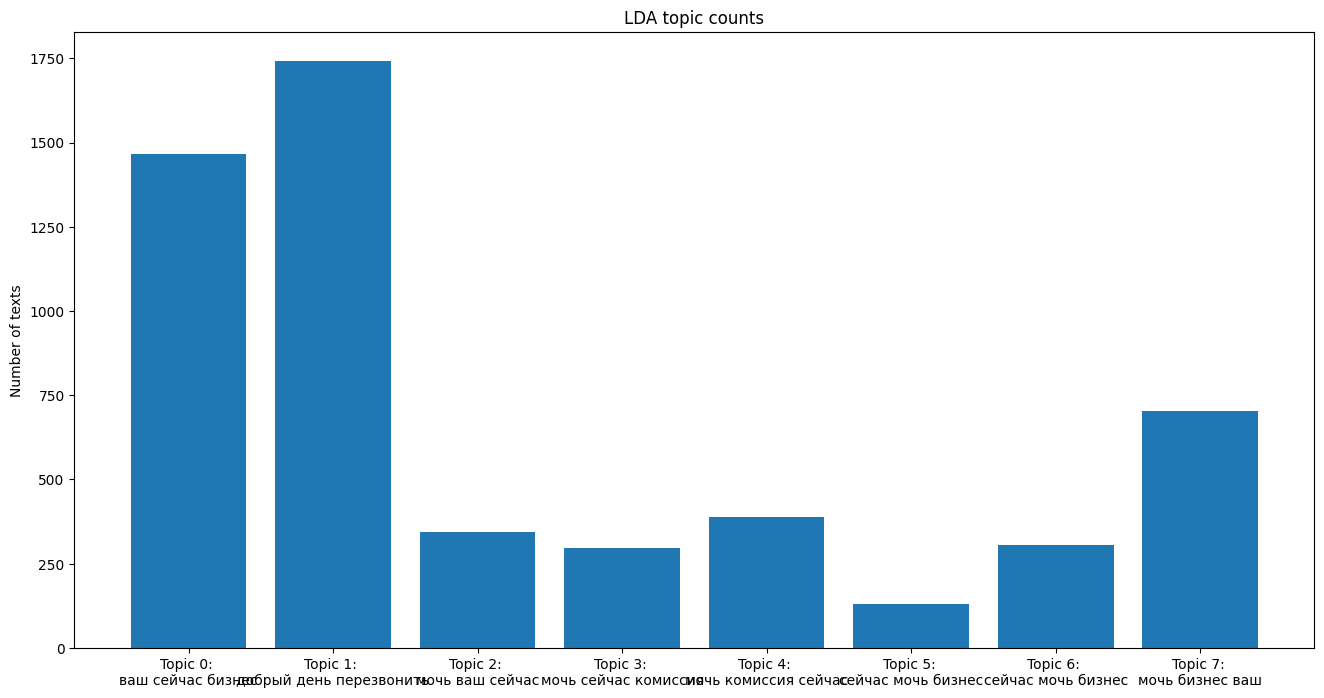

In [117]:
top_3_words = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of texts');

In [118]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5373 samples in 0.008s...
[t-SNE] Computed neighbors for 5373 samples in 0.276s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5373
[t-SNE] Computed conditional probabilities for sample 2000 / 5373
[t-SNE] Computed conditional probabilities for sample 3000 / 5373
[t-SNE] Computed conditional probabilities for sample 4000 / 5373
[t-SNE] Computed conditional probabilities for sample 5000 / 5373
[t-SNE] Computed conditional probabilities for sample 5373 / 5373
[t-SNE] Mean sigma: 0.000047
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.382172
[t-SNE] KL divergence after 2000 iterations: 0.770111


In [147]:
top_3_words_lda = get_top_n_words(3, lda_keys, document_term_matrix, count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [27]:
text = 'добрый день  это клиентский менеджер сбер бизнес организации звоню разговаривать акция карта бесплатно пользование до свидания'
vectorized = count_vectorizer.transform([text])
lda_topics = lda_model.transform(vectorized)
lda_topics

array([[0.01393793, 0.01389717, 0.01389738, 0.68437352, 0.01390266,
        0.01392417, 0.2321664 , 0.01390078]])

In [ ]:
-----------------

In [122]:
#tokenize articles
tokeize_article = df_filtered.text_employer.apply(lambda x : x.split())
id2word = corpora.Dictionary(tokeize_article)

# Create Corpus
texts = tokeize_article

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


#printing 50 words from the text corpus
corpus_example = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [128]:
texts[0]

['добрый',
 'день',
 'ваш',
 'персональный',
 'менеджер',
 'сбербанк',
 'бизнес',
 'удобно',
 'сейчас',
 'говорить']

In [130]:
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True,
                                           eta = 0.6)

In [138]:
doc_lda = lda_model_2[corpus]

for item in lda_model_2.print_topics():
    print(item)
    print('----')
# print(lda_model_2.print_topics())

(0, '0.038*"время" + 0.035*"сейчас" + 0.035*"услуга" + 0.034*"ваш" + 0.029*"день" + 0.029*"добрый" + 0.027*"быть" + 0.026*"мочь" + 0.023*"сбербанк" + 0.023*"удобно"')
----
(1, '0.027*"мочь" + 0.025*"рубль" + 0.022*"сейчас" + 0.021*"смс" + 0.021*"ваш" + 0.020*"номер" + 0.019*"срок" + 0.018*"код" + 0.017*"быть" + 0.017*"обслуживание"')
----
(2, '0.078*"добрый" + 0.072*"день" + 0.071*"перезвонить" + 0.054*"удобно" + 0.049*"менеджер" + 0.046*"бизнес" + 0.045*"сейчас" + 0.040*"сбербанк" + 0.032*"мочь" + 0.031*"сбер"')
----
(3, '0.044*"бизнес" + 0.032*"ваш" + 0.028*"снимать" + 0.027*"покупка" + 0.026*"год" + 0.024*"мочь" + 0.022*"свой" + 0.021*"комиссия" + 0.021*"предложение" + 0.020*"вносить"')
----
(4, '0.055*"терминал" + 0.048*"эквайринг" + 0.042*"комиссия" + 0.039*"оборот" + 0.031*"торговый" + 0.026*"целый" + 0.026*"месяц" + 0.020*"процент" + 0.019*"оборудование" + 0.019*"точка"')
----
(5, '0.050*"комиссия" + 0.036*"мочь" + 0.032*"процент" + 0.032*"рубль" + 0.023*"услуга" + 0.023*"физиче

In [148]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.170812 -0.043392       1        1  24.441270
1     -0.065445 -0.036629       2        1  15.767702
3      0.059135 -0.194161       3        1  14.707732
2      0.281443  0.019066       4        1  11.659386
5     -0.191092 -0.118043       5        1  11.658300
7      0.044345  0.169870       6        1   8.963011
6     -0.109077  0.242956       7        1   8.082247
4     -0.190120 -0.039668       8        1   4.720352, topic_info=            Term         Freq         Total Category  logprob  loglift
116  перезвонить  3356.000000   3356.000000  Default  30.0000  30.0000
4         добрый  7738.000000   7738.000000  Default  29.0000  29.0000
20      комиссия  4957.000000   4957.000000  Default  28.0000  28.0000
3           день  7754.000000   7754.000000  Default  27.0000  27.0000
9         удобно  5784.000000   5784.000000  Default  26.0000  26.0000
..           ...          ...           ...      ...      ...      ...
191   установить   141.519798    443.560057   Topic8  -4.9078   1.9109
8         сейчас   194.422040  10283.377993   Topic8  -4.5902  -0.9150
7       сбербанк   175.823539   6183.390659   Topic8  -4.6907  -0.5069
39        услуга   169.959195   6162.273227   Topic8  -4.7247  -0.5374
1            ваш   173.863264   9887.071943   Topic8  -4.7019  -0.9874

[508 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
593       1  0.002728  адрес
593       2  0.051840  адрес
593       3  0.002728  адрес
593       4  0.002728  адрес
593       5  0.002728  адрес
...     ...       ...    ...
425       2  0.022386  юрист
425       3  0.022386  юрист
425       4  0.022386  юрист
425       5  0.873040  юрист
425       6  0.044771  юрист

[2799 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 6, 8, 7, 5])

In [141]:
# Compute Perplexity
print('\nPerplexity : ', lda_model_2.log_perplexity(corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity :  -5.718476822558058

Coherence Score:  0.5180988969459922


In [142]:
def calculate_coherence_score(n, alpha, beta):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = CoherenceModel(model=model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]


for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)
            print(f"n : {n} ; alpha : {alpha} ; beta : {beta} ; Score : {coherence_score}")

n : 2 ; alpha : symmetric ; beta : auto ; Score : 0.419026614020857
n : 2 ; alpha : symmetric ; beta : 0.3 ; Score : 0.419026614020857
n : 2 ; alpha : symmetric ; beta : 0.5 ; Score : 0.419026614020857
n : 2 ; alpha : symmetric ; beta : 0.7 ; Score : 0.419026614020857
n : 2 ; alpha : 0.3 ; beta : auto ; Score : 0.41902661402085695
n : 2 ; alpha : 0.3 ; beta : 0.3 ; Score : 0.419026614020857
n : 2 ; alpha : 0.3 ; beta : 0.5 ; Score : 0.41902661402085695
n : 2 ; alpha : 0.3 ; beta : 0.7 ; Score : 0.41902661402085695
n : 2 ; alpha : 0.5 ; beta : auto ; Score : 0.419026614020857
n : 2 ; alpha : 0.5 ; beta : 0.3 ; Score : 0.419026614020857
n : 2 ; alpha : 0.5 ; beta : 0.5 ; Score : 0.419026614020857
n : 2 ; alpha : 0.5 ; beta : 0.7 ; Score : 0.419026614020857
n : 2 ; alpha : 0.7 ; beta : auto ; Score : 0.419026614020857
n : 2 ; alpha : 0.7 ; beta : 0.3 ; Score : 0.419026614020857
n : 2 ; alpha : 0.7 ; beta : 0.5 ; Score : 0.419026614020857
n : 2 ; alpha : 0.7 ; beta : 0.7 ; Score : 0.419026

In [143]:
n = 12
alpha = 'symmetric'
beta = 0.3
lda_best_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
coherence_model_lda = CoherenceModel(model=lda_best_model, texts=tokeize_article, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5780234071924341


In [149]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_best_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.242802  0.036868       1        1  26.679246
0      0.097319 -0.143129       2        1  14.189674
2      0.263597  0.071466       3        1  10.617455
11    -0.070685 -0.158269       4        1   8.665810
1     -0.174338  0.298329       5        1   6.845467
10     0.151042  0.123288       6        1   6.632923
9     -0.213381  0.008825       7        1   6.556168
4      0.059959 -0.090376       8        1   5.127594
6     -0.209630 -0.108615       9        1   4.114095
3     -0.026969 -0.214812      10        1   4.102194
8      0.090808  0.080384      11        1   3.310621
5     -0.210524  0.096041      12        1   3.158753, topic_info=            Term         Freq        Total Category  logprob  loglift
4         добрый  7763.000000  7763.000000  Default  30.0000  30.0000
39        услуга  6275.000000  6275.000000  Default  29.0000  29.0000
116  перезвонить  3381.000000  3381.000000  Default  28.0000  28.0000
3           день  7906.000000  7906.000000  Default  27.0000  27.0000
0         бизнес  8936.000000  8936.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
277    перевести   160.151802   523.868583  Topic12  -4.3824   2.2699
23         месяц   304.308620  2283.959880  Topic12  -3.7405   1.4394
7       сбербанк   262.526388  6340.812265  Topic12  -3.8882   0.2706
663       полный   129.884578   486.103397  Topic12  -4.5919   2.1352
286        рубль   186.535587  3357.545513  Topic12  -4.2299   0.5646

[685 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
593       5  0.335778         адрес
593       9  0.083945         адрес
593      11  0.570823         адрес
571       8  0.936529  активировать
681       1  0.958116       активно
...     ...       ...           ...
270      10  0.001666      являться
665       5  0.016267        яндекс
665       6  0.005422        яндекс
665       8  0.694055        яндекс
665      11  0.260271        яндекс

[1198 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 12, 2, 11, 10, 5, 7, 4, 9, 6])

In [ ]:
------------------

In [152]:
# LSA
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [153]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [154]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  мочь сейчас ваш бизнес добрый день сбербанк удобно услуга время
Topic 2:  комиссия рубль процент месяц тариф миллион сумма оборот целый платёж
Topic 3:  здравствуйте добрый город сбербанк линия спасибо терминал специалист эквайринг обращаться
Topic 4:  должный нажать пароль система сейчас логин заявление подписать мочь назвать
Topic 5:  терминал торговый заявление оборудование сейчас адрес точка эквайринг заполнить пункт


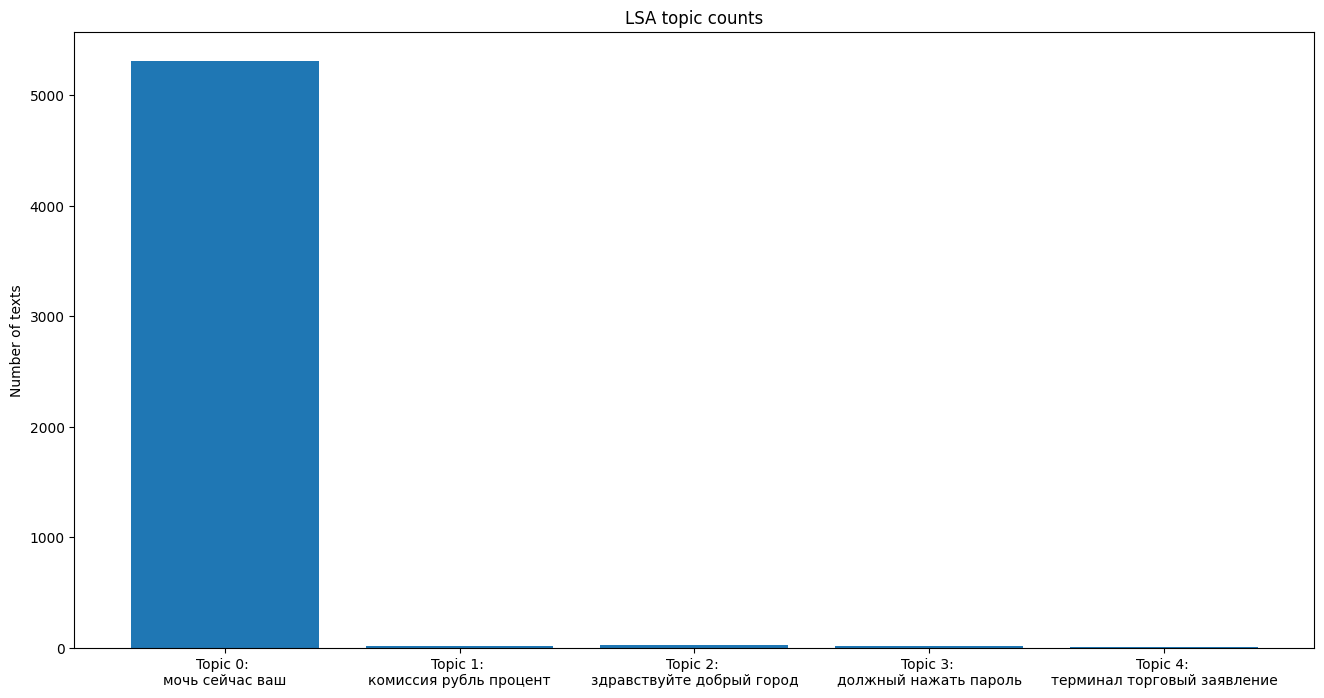

In [155]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of texts');
ax.set_title('LSA topic counts');
plt.show()

In [156]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5373 samples in 0.006s...
[t-SNE] Computed neighbors for 5373 samples in 0.284s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5373
[t-SNE] Computed conditional probabilities for sample 2000 / 5373
[t-SNE] Computed conditional probabilities for sample 3000 / 5373
[t-SNE] Computed conditional probabilities for sample 4000 / 5373
[t-SNE] Computed conditional probabilities for sample 5000 / 5373
[t-SNE] Computed conditional probabilities for sample 5373 / 5373
[t-SNE] Mean sigma: 0.295296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.298294
[t-SNE] KL divergence after 2000 iterations: 1.204207


In [157]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), width=700, height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

Выводы:

- Ранее не приходилось сталкиваться с задачей тематического моделирования, но задачка интересная. В целом использовал тот же препроцессинг, что и в 1ой задаче. Кроме того момента, что там отфильтровывал короткие текста и фразы типа приветствия, прощания и т.п. Здесь же как раз нужно научиться выделять такие подтемы.
- Изучал статьи по данной теме и некоторые работы на kaggle.
- Дополнительно еще поизучал текста, чтобы увеличить список стоп-слов для фильтрации. Кроме этого собирал слова для каждой темы, чтобы сохранить их в том случае, если при препроцессинге они отфильтруются. Также дополнительно отфильтровал высокочастотные и низкочастотные слова.
- Кажется, что некоторые темы похожи и можно было бы объединить их: "Болтовня" == Вовлечение (подведение к диалогу) и Инструкция по подключению/приобретению == Следующие шаги.
- Попробовал две библиотеки: sklearn и gensim. Два алгоритма: LSA, LDA

Как видно из визулизации LDA лучше находит границы тематик, чем LSA. Поэтому дальше с ним в большей степени и работал. Фильтрация высокочастотных и низкочастотных слов и препроцессинг заметно (визуально) улучшила результаты для LDA. Но все равно здесь еще много работы, потому что при выводе топ полезных слов для каждой темы имеются заметные пересечения. Опять же часто в этот топ попадают слова приветствия для разных тем. Чтобы более детально разобраться с темами нужно подробнее изучать более далекие слова в топе.

<img src='data/LDA_8_topics.png' width=640, heigth=480>

<img src='data/LSA_5_topics.png' width=640, heigth=480>

Кроме этого попробовал LDA алгоритм, реализованный в gensim + визуализацию через pyLDAvis. Данная комбинация мне понравилась больше. 
Что было сделано?
- визуализация + подсчет метрик. Для первого варианта Perplexity :  -5.718476822558058; Coherence Score:  0.5180988969459922.
чем ниже Perplexity, тем лучше модель и чем больше Coherence, тем опять жу лучше модель. 
Perplexity - мера того, насколько хорошо модель предсказывает детали тестовой коллекции. Перплексию можно определить как обратную вероятность тестового набора, нормализованную по количеству слов. 
Когерентность (Coherence) - метрика оценки целостности текста. 

После подбора оптимальных параметров получил Coherence Score = 0.5780234071924341
Было выделено 12 тематик по данным текстам и ключевые слова к ним. Из визуализации видно, что 3яя тема является по сути подмножеством 1ой.
1 (приветствие): Очень похож на приветствие (по ключевым словам можно понять, что человек представляется, говорит что он менеджер и представляет условный банк. Пытается узнать удобно ли собеседнику сейчас говорить)
2 (акции/преимущества): По ключевым словам кажется, что он общается с клиентом, который уже пользуется услугами банка. При этом он рассказывает про акции и некие преимущества чего-то
3 (приветствие): Идентично 1ой теме, только разнообразие и колчество токенов меньше.
4 (стоимость, тарифы, цены): в целом без сомнения можно назвать тему стоимости услуг.
5 (инструкция): некая инструкция для оформления заявления через компьютер
6: я бы сказал это человек из технической поддержки помогает клиенту
7: что-то про выпуск новой карты, как это сделать, стоимость и обслуживание
8: я бы сказал есть что-то общее между 2ой и 5ой темой. Хотя по визуализации с 5ой вообще не близко. Есть еще пару моментов про мобильное приложение.
9: эквайринг, банковские терминалы, оборудование и стоимость и т.п.
10 (преимущество, стоимост, баллы):
11 (инструкция): но в данном случае уже рассказывает про электронную почту и смс-уведомления
12 (тариф/преимущества): 


Были обнаружены темы, близкие к Вами указанными топиками: приветствие, тарифы, цены, акции, преимущества, инструкции, вопрос клиента (технической поддержки = 6 тема). Частично есть пересечения. Также некоторые темы новые, я бы сказал, что они связаны с разными услугами банка (например, выпуск новой карты). 

Некоторые темы модель не смогла выделить: Перенос активности, Окончание разговора, "Болтовня", Скорость работы, Удобство работы. 
Возможно это связано с дисбалансом и малым числом диалогов на данные темы.

Я бы выделил два момента, на которых стоит сосредоточиться:
1: более детально изучать документы, улучшать препроцессинг, очищать от слов, которые не несут большого смысла для данной задачи. Также думаю у вас есть намного больше данных. Возможно стоит попробовать использовать более длинные документы.

Задумался почему приветствие лучше всего цепляется, а конец разговора нет. Возможно, из-за того что много документов, где только приветствие. Но нет отдельных разговоров для концовки. Интересная мысль, возможно, нужно руками составить датасет, в котоом нет перплетения разных тем. А просто вырезка из диалога с акциями, инструкциями, с настройками и т.д.

Также мне кажется, нужно начинать просто 3-4 тем, но для этого нужен датасет, где уделено внимание меньшему числу тем. Потом бы наращивал. Но опять же вопрос времени.

2: попробовать другие алгоритмы, идеи, подходы.

При изучении вопроса нашел интересную статью на kaggle с комбинацией разных алгоритмов, в том числе глубокого обучения: https://www.kaggle.com/code/dskswu/topic-modeling-bert-lda

<img src='data/topic_modeling.png' width=640, heigth=480>